In [4]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, RocCurveDisplay, ConfusionMatrixDisplay
)

In [5]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/praktikum_ml/praktikum03/data/stunting_wasting_dataset.csv')
df.drop_duplicates(inplace=True)
print("Shape of dataframe after dropping duplicates:", df.shape)

Mounted at /content/drive
Shape of dataframe after dropping duplicates: (92692, 6)


In [6]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/praktikum_ml/praktikum03/data/stunting_wasting_dataset.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


In [8]:
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


In [9]:
df['Stunting'].unique()


array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [10]:
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

In [11]:
map_stunt = {'Stunted':1, 'Severely Stunted':1, 'Normal':0, 'Tall':0}
df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('Int64')

df['JK_bin'] = (df['Jenis Kelamin'] == 'Laki-laki').astype(int)

print("Distribusi Stunting_bin:\n", df['JK_bin'].value_counts())
print("\nDistribusi JK_bin:\n", df['JK_bin'].value_counts())

Distribusi Stunting_bin:
 JK_bin
1    50179
0    49821
Name: count, dtype: int64

Distribusi JK_bin:
 JK_bin
1    50179
0    49821
Name: count, dtype: int64


In [12]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.875869,0.665389,0.038630,0.004046
Tinggi Badan (cm),0.875869,1.000000,0.626005,-0.283855,0.073505
Berat Badan (kg),0.665389,0.626005,1.000000,0.021090,0.045797
Stunting_bin,0.038630,-0.283855,0.021090,1.000000,-0.005981
JK_bin,0.004046,0.073505,0.045797,-0.005981,1.000000


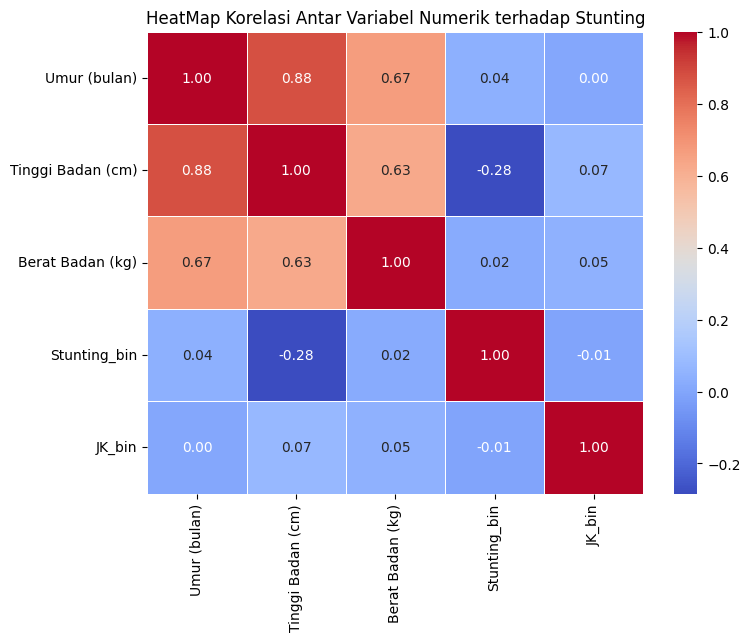

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('HeatMap Korelasi Antar Variabel Numerik terhadap Stunting', fontsize=12)
plt.show()

In [14]:
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

use_cols = feature_num + feature_bin + ['Stunting_bin']
df_model = df[use_cols].dropna().copy()

X = df_model[feature_num + feature_bin]
y = df_model['Stunting_bin']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (100000, 4)
y shape: (100000,)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)

Data latih: (80000, 4)
Data uji: (20000, 4)


In [16]:
preprocess = ColumnTransformer([
    ('num', StandardScaler(), feature_num),
    ('bin', 'passthrough', feature_bin)
], remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('preprocess', preprocess),
    ('model', model)
])

#latih Model
clf.fit(X_train, y_train)
print("Model Regression Berhasil Dilatih")

Model Regression Berhasil Dilatih


In [17]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Hitung Numerik
print(f"Akurasi : {accuracy_score(y_test, y_pred):.4f}")
print(f"Presisi : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall  : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC AUC : {roc_auc_score(y_test, y_prob):.4f}")

Akurasi : 0.9055
Presisi : 0.7152
Recall  : 0.9472
F1 Score: 0.8150
ROC AUC : 0.9656


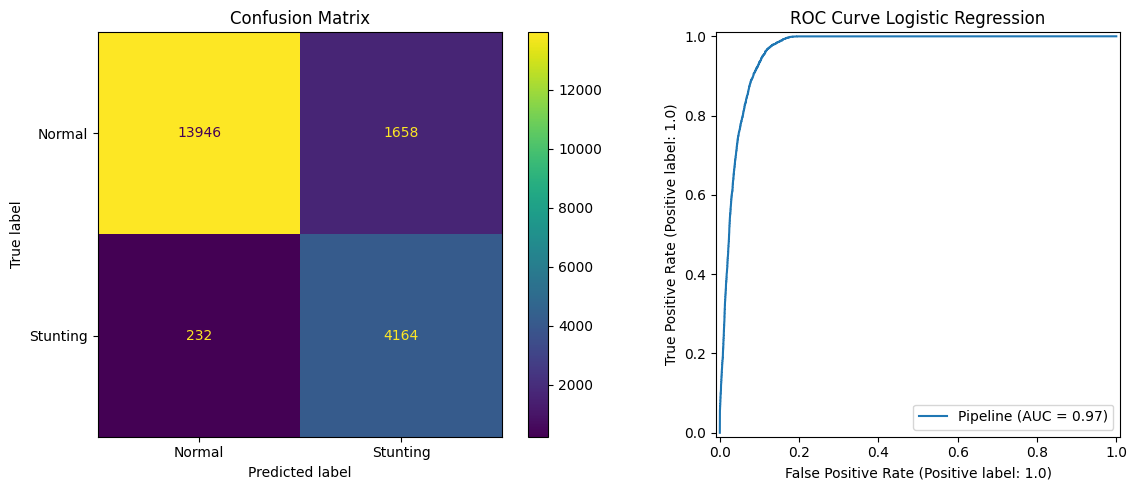

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['Normal', 'Stunting']).plot(values_format='d', ax=axes[0])
axes[0].set_title("Confusion Matrix")

RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=axes[1])
axes[1].set_title("ROC Curve Logistic Regression")

plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names= ['Tidak Stunting (0)', 'Stunting (1)']))

                    precision    recall  f1-score   support

Tidak Stunting (0)       0.98      0.89      0.94     15604
      Stunting (1)       0.72      0.95      0.82      4396

          accuracy                           0.91     20000
         macro avg       0.85      0.92      0.88     20000
      weighted avg       0.92      0.91      0.91     20000



In [20]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=5)

print("Skor tiap Fold:", scores)
print("Rata-rata Akurasi:", np.mean(scores))
print("Standart Deviasi:", np.std(scores))

Skor tiap Fold: [0.9062  0.9013  0.9052  0.89905 0.9002 ]
Rata-rata Akurasi: 0.9023899999999999
Standart Deviasi: 0.0028125433329995106


In [25]:
feat_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'Fitur': feat_names,
    'Koefisien (log-odds)': coefs,
    'Odds Ratio (e^coef)': odds
}).sort_values('Odds Ratio (e^coef)', ascending=False)

display(coef_df)

,Fitur,Koefisien (log-odds),Odds Ratio (e^coef)
0,Umur (bulan),8.525912,5043.782458
3,JK_bin,1.675944,5.343839
2,Berat Badan (kg),0.661090,1.936903
1,Tinggi Badan (cm),-10.535980,0.000027


In [23]:
data_baru = pd.DataFrame({
    'Umur (bulan)' : [24,10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)' : [9.2, 7.8],
    'JK_bin' : [1,0]
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:,1]

hasil = data_baru.copy()
hasil['Prob_Stuntung'] = prob
hasil['Pred (0=Tidak Stunting, 1=Stunting)'] = pred

display(hasil)


,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_Stuntung,"Pred (0=Tidak Stunting, 1=Stunting)"
0,24,79.0,9.2,1,0.998208,1.0
1,10,72.5,7.8,0,0.002094,0.0


PRAKTIKUM MANDIRI LOGISTIC REGRESSION

In [26]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/praktikum_ml/praktikum04/data/calonpembelimobil.csv')
df.drop_duplicates(inplace=True)
print("Shape of dataframe after dropping duplicates:", df.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of dataframe after dropping duplicates: (1000, 7)


In [33]:
print("5 Data Teratas:")
print(df.head())


print("Informasi Dataset:")
df.info()


5 Data Teratas:
   ID  Usia  Status  Kelamin  Memiliki_Mobil  Penghasilan  Beli_Mobil
0   1    32       1        0               0          240           1
1   2    49       2        1               1          100           0
2   3    52       1        0               2          250           1
3   4    26       2        1               1          130           0
4   5    45       3        0               2          237           1
Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   ID              1000 non-null   int64
 1   Usia            1000 non-null   int64
 2   Status          1000 non-null   int64
 3   Kelamin         1000 non-null   int64
 4   Memiliki_Mobil  1000 non-null   int64
 5   Penghasilan     1000 non-null   int64
 6   Beli_Mobil      1000 non-null   int64
dtypes: int64(7)
memory usage: 54.8 KB


In [35]:
print("Jumlah Missing Values:")
print(df.isnull().sum())


print("Nilai Unik Setiap Kolom:")
for col in df.columns:
  print(f"\nKolom: {col}")
  print(df[col].unique())

Jumlah Missing Values:
ID                0
Usia              0
Status            0
Kelamin           0
Memiliki_Mobil    0
Penghasilan       0
Beli_Mobil        0
dtype: int64
Nilai Unik Setiap Kolom:

Kolom: ID
[   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   22   23   24   25   26   27   28
   29   30   31   32   33   34   35   36   37   38   39   40   41   42
   43   44   45   46   47   48   49   50   51   52   53   54   55   56
   57   58   59   60   61   62   63   64   65   66   67   68   69   70
   71   72   73   74   75   76   77   78   79   80   81   82   83   84
   85   86   87   88   89   90   91   92   93   94   95   96   97   98
   99  100  101  102  103  104  105  106  107  108  109  110  111  112
  113  114  115  116  117  118  119  120  121  122  123  124  125  126
  127  128  129  130  131  132  133  134  135  136  137  138  139  140
  141  142  143  144  145  146  147  148  149  150  151  152  153  154
  155  

In [36]:
X = df[['Usia', 'Status', 'Kelamin', 'Memiliki_Mobil', 'Penghasilan']]
y = df['Beli_Mobil']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nJumlah data latih: {len(X_train)}")
print(f"Jumlah data uji: {len(X_test)}")


Jumlah data latih: 800
Jumlah data uji: 200


In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [40]:
y_pred = model.predict(X_test_scaled)


print("Akurasi Model:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))


print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred))

Akurasi Model: 0.925
Precision: 0.935251798561151
Recall: 0.9558823529411765
F1 Score: 0.9454545454545454
ROC AUC: 0.9076286764705883
Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88        64
           1       0.94      0.96      0.95       136

    accuracy                           0.93       200
   macro avg       0.92      0.91      0.91       200
weighted avg       0.92      0.93      0.92       200



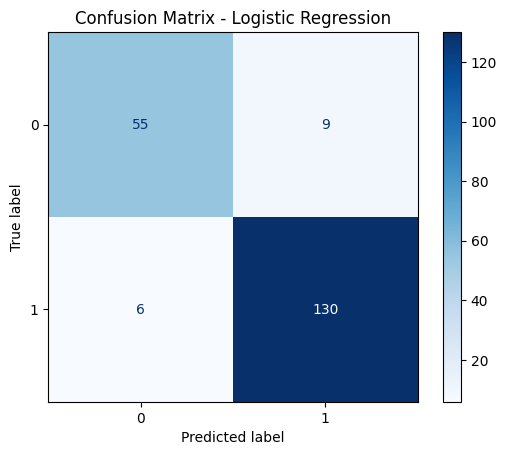

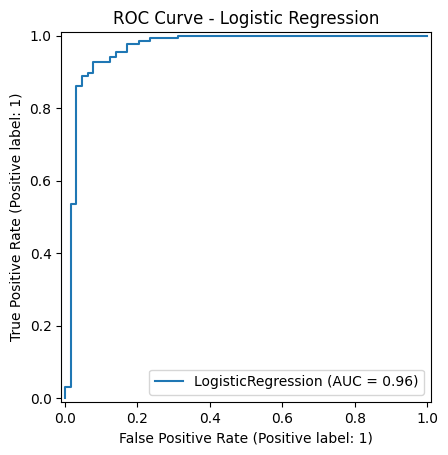

In [54]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title('ROC Curve - Logistic Regression')
plt.show()

PREDIKSI DATA BARU

In [50]:
data_baru = pd.DataFrame({
'Usia': [30, 55, 40],
'Status': [1, 2, 1],
'Kelamin': [0, 1, 0],
'Memiliki_Mobil': [0, 2, 1],
'Penghasilan': [220, 130, 300]
})

In [51]:
scaled_baru = scaler.transform(data_baru)


# Prediksi
prediksi = model.predict(scaled_baru)


hasil_prediksi = pd.concat([data_baru, pd.DataFrame({'Prediksi_Beli_Mobil': prediksi})], axis=1)
print("Hasil Prediksi Data Baru:")
print(hasil_prediksi)

Hasil Prediksi Data Baru:
   Usia  Status  Kelamin  Memiliki_Mobil  Penghasilan  Prediksi_Beli_Mobil
0    30       1        0               0          220                    1
1    55       2        1               2          130                    0
2    40       1        0               1          300                    1
